# Modèle Linéraire
Understanding PyTorch with an example: a step-by-step tutorial
And we built our own loss function.
Ready, steady, go...


## Importation

In [11]:
import numpy as np
# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.modules.loss import _Loss
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data

x -> (features) intégrale de y (bruité) sur $[0,l]$ correspondant au moment d'ordre 0 bruité ;

y -> (labels) distribution sur $[0,l]$.

In [12]:
# Physical data
l = 200
tau = 100
dep = 2
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)
# Data sample
nsamp = 400
x_dagger = np.zeros((nsamp,nx))
y = np.zeros((nsamp,nt))
x_grid = np.linspace(0,l,nx)
#
x_sample = np.zeros((nsamp,nx))
#
for i in range(0,nsamp):
    mu = l/2
    sigma = 0.1
    x_dagger[i] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    y[i] = T_operator.dot(x_dagger[i]) 
    xi = np.random.uniform(-0.005,0.005,nt)
    y[i] += xi*np.linalg.norm(y[i])/np.linalg.norm(xi)
    x_sample[i] = np.transpose(T_operator).dot(y[i])

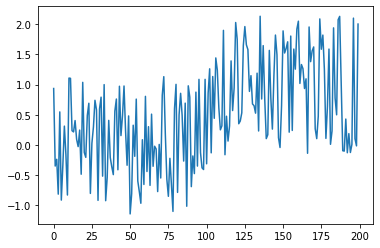

In [13]:
plt.plot(y[0])

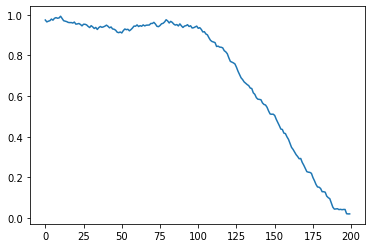

In [14]:
plt.plot(x_sample[0])

In [15]:
# Train-Test split
x_train = x_sample[:300]
y_train = x_dagger[:300]

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

In [17]:
# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


## Model - Linear regression

In [18]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, 
        # we need to wrap them with nn.Parameter
        # self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        # self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        # Now, instead of our custom parameters, 
        # we use a Linear layer with single input and single output
        self.linear = nn.Linear(nx, nx, bias= False)
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.linear(x)

In [19]:
# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.0686,  0.0338, -0.0380,  ..., -0.0552,  0.0243,  0.0228],
        [-0.0562,  0.0577,  0.0492,  ...,  0.0246,  0.0248, -0.0214],
        [-0.0118, -0.0696, -0.0518,  ..., -0.0322, -0.0074, -0.0099],
        ...,
        [ 0.0415, -0.0250,  0.0538,  ..., -0.0464, -0.0429,  0.0207],
        [ 0.0460,  0.0106, -0.0023,  ..., -0.0353,  0.0611,  0.0476],
        [ 0.0272,  0.0381,  0.0427,  ..., -0.0443, -0.0603, -0.0405]]))])


## Loss function

In [20]:
class My_custom_loss(_Loss):
    def __init__(self): 
        super(My_custom_loss, self).__init__()
 
    def forward(self, output, target):
        wo = torch.cumsum(output,dim=0)/torch.sum(output)
        wt = torch.cumsum(target,dim=0)/torch.sum(target)
        loss = torch.norm(output-target)
        return loss

In [25]:
#loss_fn = nn.MSELoss(reduction='mean')
loss_fn = My_custom_loss()

## Optimizer

In [26]:
lr = 1e-1

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

## Training Step

In [27]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [29]:
# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

## Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# train_data = CustomDataset(x_train_tensor, y_train_tensor)
# plt.plot(train_data[0][1])
# plt.plot(train_data[0][0])



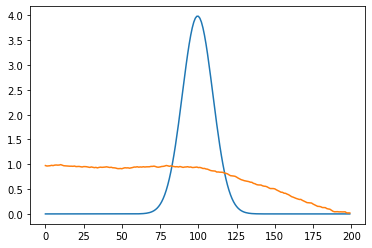

In [31]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
plt.plot(train_data[0][1])
plt.plot(train_data[0][0])

## Finale

In [32]:
n_epochs = 100
losses = []

train_loader = DataLoader(dataset=train_data, \
                          batch_size=20, shuffle=True)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.0690,  0.0333, -0.0385,  ..., -0.0543,  0.0248,  0.0231],
        [-0.0572,  0.0569,  0.0481,  ...,  0.0245,  0.0254, -0.0209],
        [-0.0084, -0.0663, -0.0474,  ..., -0.0337, -0.0097, -0.0113],
        ...,
        [ 0.0488, -0.0173,  0.0612,  ..., -0.0463, -0.0425,  0.0211],
        [ 0.0477,  0.0122, -0.0002,  ..., -0.0363,  0.0599,  0.0467],
        [ 0.0251,  0.0364,  0.0404,  ..., -0.0432, -0.0589, -0.0396]]))])


## Evaluation

In [33]:
x_tensor = torch.from_numpy(x_sample).float()
y_tensor = torch.from_numpy(x_dagger).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [300, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [34]:
val_losses = []

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

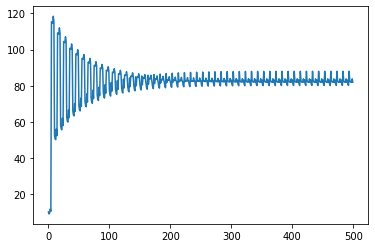

In [35]:
plt.plot(val_losses)

In [36]:
y = model(x_train_tensor[15]).detach()

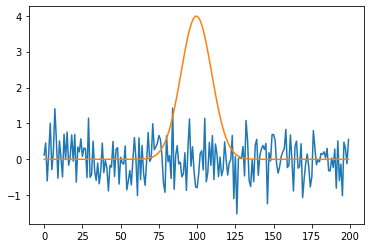

In [37]:
plt.plot(y.numpy())
plt.plot(x_dagger[12])